In [1]:
import os

os.chdir("/home/hack12/ensemble-ai2024/modelstealing")

In [2]:
import sys

sys.path.append("../end2end-stealing")

In [3]:
import torch
from taskdataset import TaskDataset


dataset = torch.load("data/ModelStealingPub.pt")

/home/hack12/ensemble-ai2024/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
len(dataset)

13000

In [5]:
import vision_transformer as vits
import torchvision.models as models
import torchvision
import numpy as np

In [6]:
victim_model = models.__dict__["resnet50"]()
checkpoint = torch.load(
    "/home/hack12/ensemble-ai2024/end2end-stealing/pretrained_weights/checkpoint_0099.pth.tar",
    map_location="cpu",
)
state_dict = checkpoint["state_dict"]
for k in list(state_dict.keys()):
    # retain only encoder up to before the embedding layer
    if k.startswith("module.encoder") and not k.startswith("module.encoder.fc"):
        # remove prefix
        state_dict[k[len("module.encoder.") :]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]
# print("state dict", state_dict.keys())
victim_model.load_state_dict(state_dict, strict=False)
victim_model.fc = torch.nn.Identity()
victim_model.cuda()
victim_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
dataset[0]

(73838,
 <PIL.Image.Image image mode=RGB size=32x32 at 0x7FB313196520>,
 '40019202')

In [8]:
features = []
to_tensor = torchvision.transforms.ToTensor()

for iid, img, label in dataset:
    with torch.no_grad():
        img = img.convert("RGB")
        img = to_tensor(img).unsqueeze(0)

        victim_model(img.to("cuda"))
        features.append(victim_model(img.to("cuda")).cpu().numpy())

In [9]:
features = torch.from_numpy(np.array(features))
features = features.view(features.shape[0], -1)

In [10]:
features.shape

torch.Size([13000, 2048])

In [11]:
import umap

In [17]:
reducer = umap.UMAP()

AttributeError: module 'umap' has no attribute 'UMAP'

In [123]:
embs = reducer.fit_transform(features)

In [124]:
labels = [label for iid, img, label in dataset]

In [125]:
label_map = {l: i for i, l in enumerate(set(labels))}

In [126]:
labels_int = [label_map[l] for l in labels]

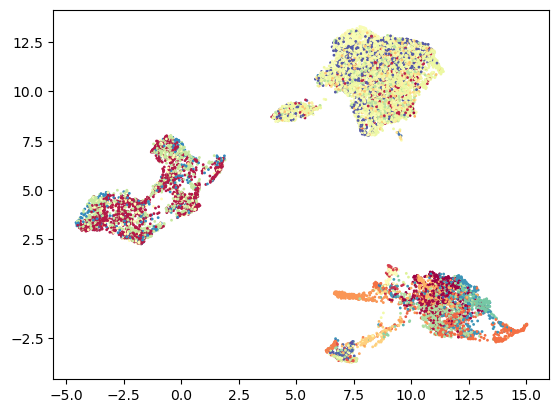

In [127]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    embs[:, 0], embs[:, 1], label=labels_int, c=labels_int, cmap="Spectral", s=1
)
plt.show()

In [29]:
images_to_return = []
features_to_return = []
indexes = []

random_index = torch.randint(low=0, high=len(features), size=(1,))

features_to_return.append(features[random_index])
images_to_return.append(dataset[random_index])
indexes.append(random_index)

distances = torch.cdist(features[indexes], features)
sum_distances = torch.sum(distances, dim=0, keepdim=True)
max_value_index = torch.argmax(sum_distances)
max_value_index

tensor(201)

In [37]:
features.shape

torch.Size([13000, 2048])

In [46]:
import random

def get_wodzes(features, dataset, n_wodzes = 10, near_dist = None):

    images_to_return = []
    features_to_return = []
    indexes = []

    random_index = random.randint(0, len(features))

    features_to_return.append(features[random_index])
    images_to_return.append(dataset[random_index])
    indexes.append(random_index)

    near_indices = []
    near_images = []

    for i in range(n_wodzes):
        distances = torch.cdist(features[indexes], features)
        sum_distances = torch.sum(distances, dim=0, keepdim=True)
        max_value_index = torch.argmax(sum_distances).item()
        if near_dist is not None:
            max_val_distances = torch.cdist(features[max_value_index], features)
            mask = max_val_distances < near_dist
            indices = torch.nonzero(mask, as_tuple=False)
            near_indices.extend(indices)
            near_images.extend([dataset[i] for i in indices])
        indexes.append(max_value_index)
        images_to_return.append(dataset[max_value_index])

    indexes.extend(near_indices)
    images_to_return.extend(near_images)

    return features[indexes], images_to_return


IndexError: list index out of range

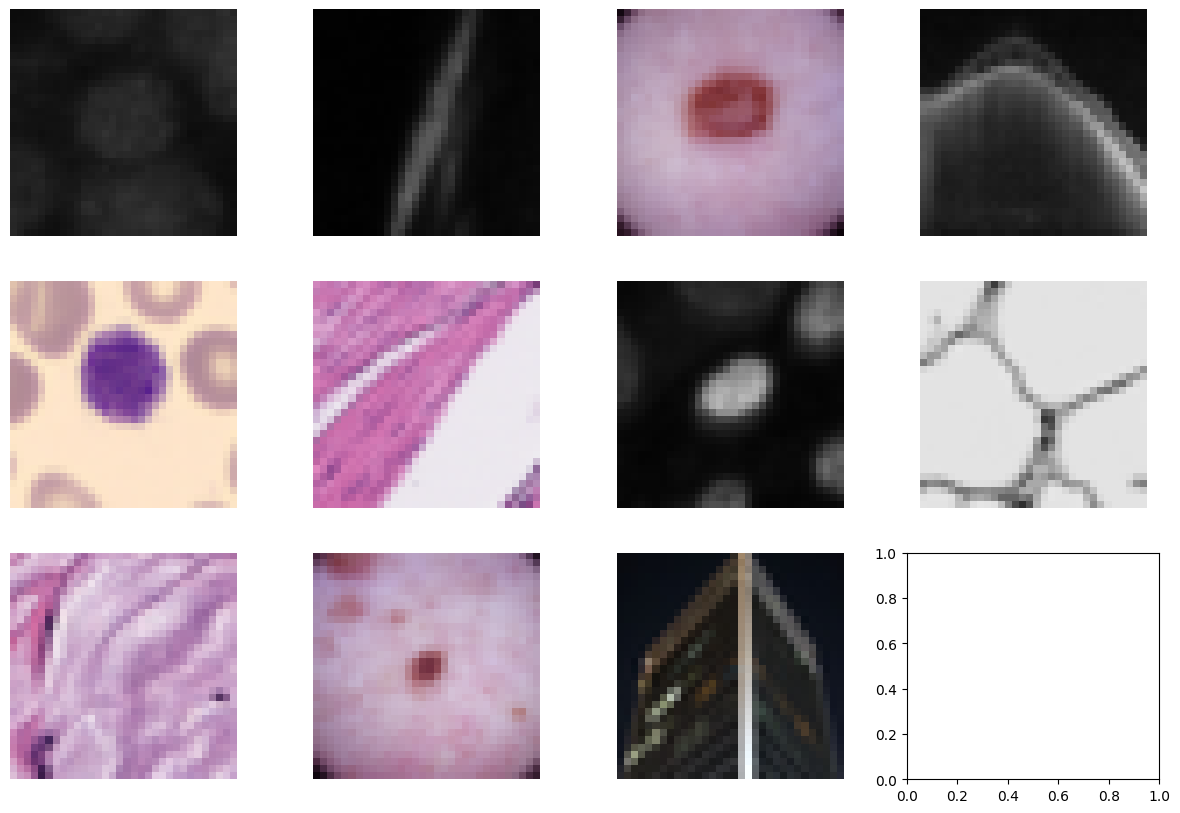

In [57]:
import matplotlib.pyplot as plt

xd_feat, xd_images = get_wodzes(features, dataset)



def plot_images(xd_images):
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))

    for i, ax in enumerate(axs.flatten()):
        ax.imshow(xd_images[i][1])
        ax.axis('off')

    plt.tight_layout()
    plt.show()
plot_images(xd_images)

In [94]:
distances = torch.cdist(features, features)

In [95]:
distances.shape

torch.Size([13000, 13000])

In [101]:
order = list(distances.mean(dim=1).sort()[1])[::-1]

In [103]:
order = [x.item() for x in order]

In [105]:
all_images = [img for iid, img, label in dataset]
chosen_images = np.array(all_images)[order][:100]

/tmp/ipykernel_71570/3161812555.py:2: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  chosen_images = np.array(all_images)[order][:100]
/tmp/ipykernel_71570/3161812555.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chosen_images = np.array(all_images)[order][:100]


In [106]:
len(chosen_images)

100

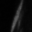

In [107]:
chosen_images[0]

In [108]:
chosen_features = features[order][:100]

In [109]:
sorted_embs = embs[order]